In [1]:
from toolkit.logger import Logger
from toolkit.classes import DataFrameCreator
from toolkit.pytorch_tools import CustomImageDataSet, setup_cuda
from torchvision.transforms import Compose, Grayscale, Resize

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
logger = Logger(__name__).get_logger()

In [3]:
logger.info("Setting up CUDA")
dev = setup_cuda()

In [4]:
data = DataFrameCreator()

In [5]:
data.load_dataset("./data/raw")

In [6]:
transform = Compose([
    Grayscale(),
    Resize((64, 64))
])

train_data = CustomImageDataSet(
    data.train["file"].astype(str), data.train["category"], transform=transform
)
validation_data = CustomImageDataSet(
    data.validation["file"], data.validation["category"], transform=transform
)
test_data = CustomImageDataSet(
    data.test["file"], data.test["category"], transform=transform
)

In [7]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

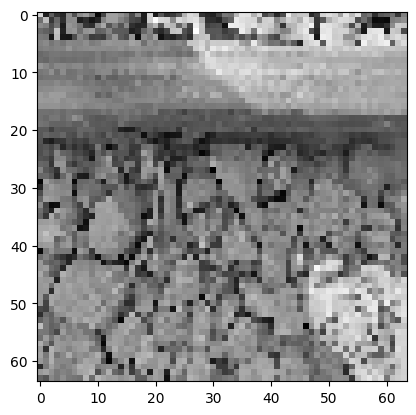

In [8]:
feat, label = next(iter(train_loader))
img = feat[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()